# Shazam for ES 156 (Spring 2019).

**Acknowledgments: ** several of the provided functions are taken the https://github.com/worldveil/dejavudataset, all credits to that repo. We also acknowledge Prof. Paul Cuff (Princeton) whose lab is the basis for this lab's structure.

# Introduction
How does Shazam work?

Shazam is a popular app for recognizing a song from a short audio sample. Shazam started its operations in the year 2000, well before smartphones came out. Back then, you would have called a number on you (dumb) mobile phone, and song identification would be made directly from the mobile phone's microphone. The name of the song would then be texted back to you.

The goal of this programming exercise is for you to implement a simplified version of Shazam. The algorithm behind Shazam is essentially a sequence of Fourier transforms taken over different time windows to form a "spectrogram" of an audio snippet. Only the largest values of the spectrogram are kept. This is done to speed up the matching with a song in a database and to provide robustness against noise. A special type of hashing algorithm is then used to match the spectrogram peaks of the audio recorded with your phone against examples in a database.

Before starting the programming exercise, give this paper a quick look:
https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf

This is the original "Shazam" paper, where the full algorithm is described in significant detail. We won't implement the whole thing (in particular, we will skip the hashing part), but hopefully by the end of the notebook you will have a solid idea of how Shazam works.

There are a lot of moving parts in this code, but don't be indimidated! If you end up getting stuck or hung-up on something, let the teaching staff know. As usual, we are excited to help you. We also appreciate your feedback and suggestions. Finally, if you find a way of improving the algorithm below, please let us know!

# Preliminaries: Importing packages and data cleanup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports
First we start by importing a few packages we will use. You may have to install some of these packages in your anaconda python setup. Please contact the teaching staff if you run into issues.

In [2]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install -q pyaudio
!pip install -q pydub

from pydub import AudioSegment
from scipy import signal
from operator import itemgetter
import pyaudio
import numpy as np
import sys
sys.path.append('/content/gdrive/My Drive/2020-es156-shazam')
import utils
import os
import warnings
import operator
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.4).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 1s (260 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 144568 files and directories currently installed.)
Prepari

# Settings 

We now define a few parameters that will be used throughout the lab. These values define different aspects of how the (real-valued) audio signal will be sampled and transformed into a discrete-time signal. The main components are the number of audio channels (2 -- left and righ), the sampling rate (44.1 KHz), the down sampling factor, and the window size of the FFT (recall that the FFT is just an algorithm that implements the DFT). These value are fairly standard in audio signal processing.

Parameters to pay attention to: 
1. Fan Value: The way Shazam's hashing function works is by hashing *pairs* of peaks in the audio signal. This means the song's fingerprints are determined not just individual peaks, but also by the differences between peak pairs. (More on this in part 6). The fan value is the maximum number of pairs each peak can be part of. Therefore, it limits the number of pairs (and therefore fingerprints) we have for the signal. 

2. Overlap Ratio: When we take the spectrogram of our signal, we want there to be an overlap between our blocks of FFTs. The overlap ratio is the ratio of the number of samples that overlap to the number of samples in each FFT block. In other words, # of overlapping samples = # of samples per block * overlap ratio 

Note:

- Tuning these values will (likely) change the system's performance. You can try to play around with the parameters but, for your first pass, leave the values below.

- Beware cautioned that there is often a tradeoff between system accuracy and system efficiency if/when you attempt to tune these values

In [3]:
FORMAT = pyaudio.paInt16

'''
Number of audio channels in the recording
'''
CHANNELS = 2

'''
Original sample rate of the recordings
'''
SAMPLE_RATE = 44100


'''
Sampling rate (after downsampling)
'''
FS = 8000

'''
Factor by which the original signal will be downsampled
'''
DECIMATION_FACTOR = SAMPLE_RATE/FS

'''
Size of the FFT window, affects frequency granularity (we saw this in class!)
'''
WINDOW_SIZE = 1024

'''
Degree to which a fingerprint can be paired with its neighbors --
higher will cause more fingerprints, but potentially better accuracy.
'''
FAN_VALUE = 15

'''
Ratio by which each window overlaps the previous and next window -- 
higher will cause more fingerprints, but higher granularity of offset matching
'''
OVERLAP_RATIO = 0.5

path = sys.path[-1]
print(path)
warnings.filterwarnings("ignore", message="divide by zero encountered in log10")
warnings.filterwarnings("ignore", category=DeprecationWarning)

/content/gdrive/My Drive/2020-es156-shazam


## Part 1: Data import and cleanup

Next, we will first construct an initial library of songs by doing the following:
1. Open each song in our raw mp3s folder; 
2. Extract the data from each of the 2 channels.

The recordings are all sampled at 44.1 KHz. (We will downsample in the next section) 

The dictionary `SongDb` will store the audio data. So `SongDb[s]` returns 2 arrays that contains the data for the first and second channel (i.e., the left and right channel) of the song `s`. 

In [4]:
# Database with key=songname, value=[channel1, channel2] 
SongDb = {}

#Goes through mp3s folder and adds each song to database
for filename in os.listdir(path + "/mp3s/"):
    if filename != '__MACOSX':
      audiofile = AudioSegment.from_file(path + "/mp3s/" + filename) 
      data = np.fromstring(audiofile._data, np.int16)
      channels = []
      for chn in range(audiofile.channels):
        channels.append(data[chn::audiofile.channels])
      SongDb[filename[:-3]] = channels
      print("Added to song database: " + str(filename[:-4]))

Added to song database: Adele - Rolling in the deep
Added to song database: Michael Jackson - Billie Jean
Added to song database: Rihanna -  Disturbia
Added to song database: The Beatles - Let It Be
Added to song database: Whitney Houston - I Will Always Love You



# Part 2: Preprocessing the Signals

Before we create fingerprints for the songs, we must preprocess the data as follows:
1. Combine the two data channels by: 
    - Taking their mean 
    - Subtracting mean to eliminate the cluster of peaks at frequency f = 0
2. Downsampling the signal so that we don't have an excess of data

The function Preprocess() should take as input a song's channels, and return the processed signal x above.

The dictionary `ProcessedDb` will store the processed audio data. So `ProcessedDb[s]` returns a single array of the combined, processed data for the song `s`.

We do the pre-processing for you, so you can focus on the singal processing aspects of the problem. Nevertheless, please make sure you understand the code below.

In [0]:
def Preprocess(channels):
    channel1 = channels[0]
    channel2 = channels[1]
    channelmean = ((channel1 + channel2)/2 - np.mean(channel1 + channel2))
    resampled = signal.decimate(channelmean, int(DECIMATION_FACTOR))
    return resampled

In [6]:
# Database with key=songname, value=processed signal
ProcessedDb = {}


#Processes each song and adds it to ProcessedDb
#Prints table of number of samples in for each song
print('{0:65}{1:22}{2:20}\n'.format('Song Name', 'Original #Samples',  'Processed #Samples'))
for song, sig in SongDb.items():
    processed = Preprocess(sig)
    ProcessedDb[song] = processed
    original_duration = len(sig[0])
    processed_duration = len(processed)
    print('{0:50}{1:32d}{2:20d}'.format(song, original_duration, processed_duration))

Song Name                                                        Original #Samples     Processed #Samples  

Adele - Rolling in the deep.                                              10111104             2022221
Michael Jackson - Billie Jean.                                            16920576             3384116
Rihanna -  Disturbia.                                                     10525824             2105165
The Beatles - Let It Be.                                                  21436288             4287258
Whitney Houston - I Will Always Love You.                                 11810476             2362096



# Part 3: construct spectrograms

- Now we want to construct the spectrogram of this signal. A (very) useful tool for this is the matplotlib.mlab spectrogram function. We want to specify the following parameters:
    1. noverlap: the number of samples that will overlap between adjacent chunks
    2. nfft: is the length of the fft you would like to take (can be the same as window)
    3. fs: the sampling rate of the signal

You can get the full documentation for the matblotlib.mlab spectrogram function here https://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram)


- After getting the spectrogram: 
    1. it is a good idea to use the log of its magnitudes (scaled by a constant factor of ~10) instead of just the raw magnitudes 
    2. It is also a good idea to set values returned as ±∞ (from divide by zeros) as 0 
    

#### Problem 1: implement a function called `getSpectrogram()` that takes a signal as an input, and returns an array with the log of the magnitudes as defined above.

In [7]:
def getSpectrogram(signal):
    s = mlab.specgram(signal, NFFT = WINDOW_SIZE, Fs = FS, noverlap = OVERLAP_RATIO*WINDOW_SIZE)[0]
    s = 10*np.log10(s)
    s[s == -np.inf] = 0
    return s
getSpectrogram(ProcessedDb['Adele - Rolling in the deep.'])

array([[  30.98959168,   30.98959168,   30.98959168, ...,   30.9978278 ,
          30.99502925,   30.99399841],
       [  27.99200675,   27.99200675,   27.99200675, ...,   28.0009373 ,
          27.99888389,   27.99733925],
       [ -35.71746274,  -35.71746269,  -35.71746269, ...,  -34.68631741,
         -32.34383544,  -33.52234127],
       ...,
       [-170.95211637, -170.95417379, -170.94833518, ...,  -99.69281703,
        -100.91840196, -106.78848567],
       [-176.96131192, -176.96159591, -176.97192491, ..., -102.9394835 ,
        -105.00734485, -107.70913262],
       [-249.84613163, -246.57059681, -243.23000391, ..., -113.67035839,
        -115.35658464, -106.14320795]])

#### Problem 2: create a dictionary called `Spectrograms` that stores the spectrogram of each song, and plot the spectrogram of each song.

Your plots should look something like `spectrogram_examples.png` included in this folder.

Of course, use the colors and fonts for each plot that you like the most
    
- The dictionary `Spectrograms` will store the processed audio data. So `Spectrograms[s]` returns an array representing the spectrogram data for the song `s`

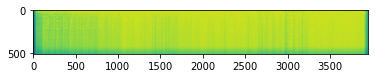

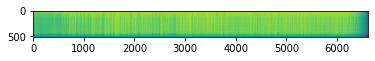

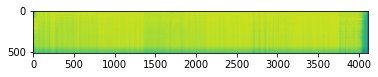

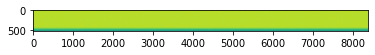

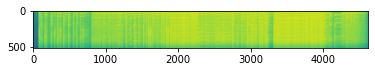

In [8]:
''' TODO '''
# Database with key=songname, value=spectrogram
Spectrograms = {}

# Gets the spectrogram for each song and adds it to the Spectrograms database
for song, sig in ProcessedDb.items():
  Spectrograms[song] = getSpectrogram(sig)
# Plots each spectrogram
for song, sig in Spectrograms.items():
  fig, ax = plt.subplots()
  ax.imshow(Spectrograms[song])
  plt.show()


# Part 4: spectrogram local peaks

The algorithm implemented by Shazam does not keep the entire spectrogram of the data. It would be to computationally intensive to match a song with w reference spectrogram by searching accross the entire time-frequency pairs. Moreover, the signal collected by the microphone on your phone is very noisy, so a lot of information in the spectrogram is useless. Instead, we only keep the largest (peak) values of the spectrogram. Those are the largest frequency components that, hopefully, can be clearly distinguished from the noise.

Next, we will implement a function that gets the local peaks of the spectrogram and plot them.
    - We use our get_2D_peaks() function defined in utils.py. 
    - This function will take a spectrogram as input. 
    - Recall that, by now, your spectrograms are saved in a dictionary.
    - The output is a triple of: 
        1. the array frequency indices of each peak
        2. the array of time indices of each peak
        3. the array of peaks as (frequency value ,time value) 
    
    

- The dictionary `Peaks` will store the processed audio data. So `Peaks[s]` returns an array of the local peaks for the song `s` where each peak is a tuple of (frequency value, time value) 

#### Problem 3: using the function `utils.get_2D_peaks`, plot the peaks of the spectrogram on a time-frequency plot. for each spectrogram in the disctionary `Spectrograms`. Store the corresponding peak values in a dictionary `Peaks`.

Your plots should look something like `2dpeaks_examples.png` included in this folder (the colors, fonts, etc. are, of course, up to you). 

The `Peaks` dictionary will play the role of the database that Shazam has. Later on, you will try to match the spectrogram peaks in a recording with the peaks in the dictionary `Peaks`.

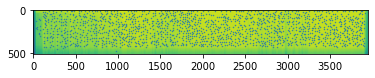

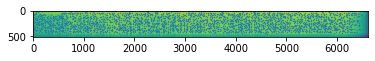

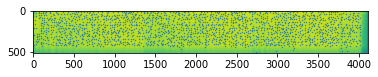

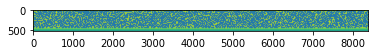

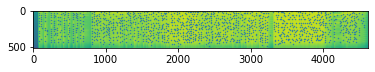

In [9]:
''' TODO '''
# Database with key=songname, value=array of local peaks
Peaks = {}

# Gets the local peaks for each song and adds it to the Peaks database
for song, sig in Spectrograms.items():
  Peaks[song] = utils.get_2D_peaks(sig)[2]
  Peaks[song] = list(zip(*Peaks[song])) 

# Plots the peaks over the original spectrogram
for song, sig in Peaks.items():
  freq, time = Peaks[song]
  fig, ax = plt.subplots()
  ax.scatter(time, freq, s = 0.2)
  ax.imshow(Spectrograms[song])
  plt.show()


# Part 5: thresholding

We want to use only the largest spectrogram peaks for each song, and specifically, the largest peaks in each time segment.

Next, you will simplify the dictionary `Peaks` in order to keep on the 20 largest peaks. You can adjust this value to more or less peaks -- more peaks makes the matching more accurate, but the matching process overall much slower. In our case we are only using 5 songs so its not a big deal. If you were matching recordings against millions of songs (for thousands of users simultaneously), the number of peaks could be an issue.

#### Problem 4: simplify the dictionary `Peaks` in order to keep only the 20 largest spectrogram peaks per song.

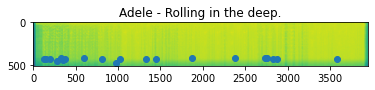

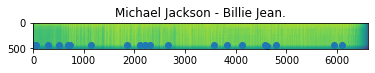

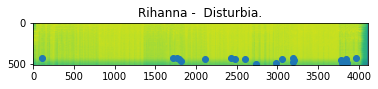

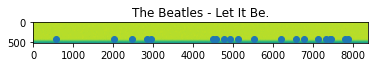

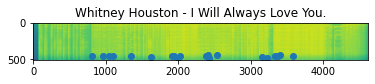

In [10]:
''' TODO '''
# Goes through the peaks of each song and sorts them 
# Updates Peaks database to (at most) 20 largest peaks
for song, sig in Peaks.items():
  l = len(Peaks[song][0])
  Peaks[song] = sorted(Peaks[song])
  Peaks[song][0] = Peaks[song][0][l-20:]
  Peaks[song][1] = Peaks[song][1][l-20:]
for song, sig in Peaks.items():
  f, t = Peaks[song]
  fig, ax = plt.subplots()
  ax.scatter(t, f)
  ax.title.set_text(song)
  ax.imshow(Spectrograms[song])
  plt.show()




# Part 6: peak pairing and table construction

How can the peaks in our `Peaks` dictionary be matched against a recording? One of the main challenges is that our peaks are timestamped, and we don't know exactly to which instant of the song the audio recording that we have corresponds to. Finding this offset can be computationally intensive. Shazam deals with this time offset issue in a very clever way: instead of matching peaks, it looks at the **time difference** between spectrogram peaks.

The final stage in creating our song fingerprints is to find pairs of peaks, and record a) their respective frequencies and b) the time difference between them. Peak pairs should meet the following constraints: 
    1. The second peak must occur within a certain time interval after the first peak
    2. Each peak can only be part of a certain number of pairs (this pair limit is defined in our globals as FAN_VALUE)
    

#### Problem 5: Creat the function getPairs() should take the peaks of a given song and return the peak pairs defined above. This corresponds to the processing done when we record an audio with your phone.


#### Problem 6: Create a dictionary `LookUpTable` that stores the peak pairs and their corresponding songs. So `LookUpTable[p]` returns the title of the song containing peak pair `p`. This function emulates the database search done by Shazam

In [11]:
''' TODO '''
def getPairs(peaks):
    peakpairs = []
    for i in range(0, len(peaks[0])):
      counter = 0
      for j in range(i+1, len(peaks[0])):
        a = peaks[0][i]
        b = peaks[0][j]
        c = abs(peaks[1][j] - peaks[1][i])
        counter = counter + 1
        peakpairs.append((a,b,c))
        if counter == 15:
          break
        else:
          continue
    return peakpairs
len(getPairs(Peaks['Adele - Rolling in the deep.']))

180

In [12]:
''' TODO '''
# Database with key=fingerprint (f1, f2, tdelta), value=songname
LookUpTable = {}
for song, sig in Peaks.items():
  print(song, len(getPairs(sig)))
  for i in getPairs(sig):
    LookUpTable[i] = song

# Get fingerprints for each song stores them in the LookUpTable database
# Prints a sample of the LookUpTable entries
# print(LookUpTable)

Adele - Rolling in the deep. 180
Michael Jackson - Billie Jean. 180
Rihanna -  Disturbia. 180
The Beatles - Let It Be. 180
Whitney Houston - I Will Always Love You. 180


# Part 7: test from files

#### Problem 7: Now we can test your Shazam!
- You can access mp3s pulled from youtube video recordings of these songs are stored in the folder test_mp3s
- Take a short snippet of these recordings and run the same fingerprinting process to getting peak pairs
- Match the pairs against our peak pairs LookUpTable and see if you match the correct song!

In [13]:
# Database with key=songname, value=[channel1, channel2] for a snippet of the song
TestDb = {}

# Goes through test_mp3s folder and adds a snippet of each song to database 
for filename in os.listdir(path + "/test_mp3s/"):
  if filename != '__MACOSX':
    audiofile = AudioSegment.from_file(path + "/test_mp3s/" + filename) 
    data = np.fromstring(audiofile._data, np.int16)[SAMPLE_RATE*60:SAMPLE_RATE*75]
    channels = []
    for chn in range(audiofile.channels):
        channels.append(data[chn::audiofile.channels])
    TestDb[filename] = channels
    print ("Added to test database: " + str(filename))

Added to test database: Adele - Rolling in the Deep.mp3
Added to test database: Beatles - Let It Be [1970].mp3
Added to test database: Let It Be (Remastered 2009).mp3
Added to test database: Michael Jackson - Billie Jean (Official Music Video).mp3
Added to test database: Rihanna - Disturbia.mp3
Added to test database: Whitney Houston - I Will Always Love You (Official Music Video).mp3


In [14]:
''' TODO '''
# Goes through test snippets and runs same fingerprinting process
# Prints out the number of matches for each song and confidence of prediction
NewProcessedDb = {}
for song, sig in TestDb.items():
    processed = Preprocess(sig)
    NewProcessedDb[song] = processed
    original_duration = len(sig[0])
    processed_duration = len(processed)
    print('{0:50}{1:32d}{2:20d}'.format(song, original_duration, processed_duration))

NewSpectrograms = {}
for song, sig in NewProcessedDb.items():
  NewSpectrograms[song] = getSpectrogram(sig)

NewPeaks = {}
for song, sig in NewSpectrograms.items():
  NewPeaks[song] = utils.get_2D_peaks(sig)[2]
  NewPeaks[song] = list(zip(*NewPeaks[song])) 
  #print(song, len(NewPeaks[song][0]))

for song, sig in NewPeaks.items():
  l = len(NewPeaks[song][0])
  NewPeaks[song] = sorted(NewPeaks[song])
  NewPeaks[song][0] = NewPeaks[song][0][l-20:]
  NewPeaks[song][1] = NewPeaks[song][1][l-20:]

matches = 0
for i in getPairs(NewPeaks['Adele - Rolling in the Deep.mp3']):
  if i in LookUpTable:
    matches = matches + 1
  else:
    continue
print(matches)

0
